In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !cp '/content/drive/MyDrive/spectrograms.zip' .

In [ ]:
# !unzip -q spectrograms.zip

In [ ]:
# !pip list

In [ ]:
# !rm -r /content/logs

rm: cannot remove '/content/logs': No such file or directory


In [ ]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

# tf.config.run_functions_eagerly(True)

In [ ]:
SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 50
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 50
EPOCHS = 75

NUM_TRAIN = 1500
NUM_VAL = 500
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

NUM_LANGUAGES = 1
LANGUAGES = ['EN','ES','FR']

LOG_DIR = "/content/logs/model" + str(NUM_LANGUAGES) + "-"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.0001

In [ ]:
BASE_DIR_EN = '/content/spectrograms/en/clips/'
TRAIN_PATH_EN = '/content/spectrograms/en/train.tsv'
TEST_PATH_EN = '/content/spectrograms/en/test.tsv'
VAL_PATH_EN = '/content/spectrograms/en/val.tsv'

NUM_TRAIN_EN = NUM_TRAIN
NUM_VAL_EN = NUM_VAL
NUM_TEST_EN = NUM_TEST

LABELS_EN = ['zero','one','two','three','four','five','six','seven','eight','nine','ten','Hey','yes','no','Firefox']
NUM_LABELS_EN = len(LABELS_EN)

In [ ]:
BASE_DIR_ES = '/content/spectrograms/es/clips/'
TRAIN_PATH_ES = '/content/spectrograms/es/train.tsv'
TEST_PATH_ES = '/content/spectrograms/es/test.tsv'
VAL_PATH_ES = '/content/spectrograms/es/val.tsv'

NUM_TRAIN_ES = NUM_TRAIN
NUM_VAL_ES = NUM_VAL
NUM_TEST_ES = NUM_TEST

LABELS_ES = ['cero','cinco','cuatro','dos','Firefox','Hey','no','neuve','ocho','seis','siete','tres','uno','sí']
NUM_LABELS_ES = len(LABELS_ES)

In [ ]:
BASE_DIR_FR = '/content/spectrograms/fr/clips/'
TRAIN_PATH_FR = '/content/spectrograms/fr/train.tsv'
TEST_PATH_FR = '/content/spectrograms/fr/test.tsv'
VAL_PATH_FR = '/content/spectrograms/fr/val.tsv'

NUM_TRAIN_FR = NUM_TRAIN
NUM_VAL_FR = NUM_VAL
NUM_TEST_FR = NUM_TEST

LABELS_FR = ['zéro','un','deux','trois','quatre','cinq','six','sept','huit','neuf','dix','Hey','oui','non','Firefox']
NUM_LABELS_FR = len(LABELS_FR)

In [ ]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

# def processdata(file):
#     waveform,sample_rate = librosa.load(file, SAMPLE_RATE)
#     waveform = padaudio(waveform)
#     mfccs = librosa.feature.mfcc(waveform,sr=sample_rate,n_mfcc=N_MFCC)
#     mfccs = np.moveaxis(mfccs,1,0)
#     scaler = StandardScaler()
#     mfccs_scaled = scaler.fit_transform(mfccs)
#     return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1],1)

def processdata(file):
  filename = file.split(".")[0] + '.pkl'
  with open(filename,'rb') as f:
    spectrogram = pickle.load(f)

  return spectrogram

In [ ]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [ ]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [ ]:
dftrainEN = pd.read_csv(TRAIN_PATH_EN, sep='\t', header=0)
dftrainEN.sort_values(by='length',ascending=False,inplace=True)
trainxEN,trainyEN, = getdata(dftrainEN.head(NUM_TRAIN_EN), BASE_DIR_EN)

dfvalEN = pd.read_csv(VAL_PATH_EN, sep='\t', header=0)
dfvalEN.sort_values(by='length',ascending=False,inplace=True)
valxEN,valyEN, = getdata(dfvalEN.head(NUM_VAL_EN), BASE_DIR_EN)

dftestEN = pd.read_csv(TEST_PATH_EN, sep='\t', header=0)
dftestEN.sort_values(by='length',ascending=False,inplace=True)
testxEN,testyEN, = getdata(dftestEN.head(NUM_TEST_EN), BASE_DIR_EN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dftrainES = pd.read_csv(TRAIN_PATH_ES, sep='\t', header=0)
dftrainES.sort_values(by='length',ascending=False,inplace=True)
trainxES,trainyES, = getdata(dftrainES.head(NUM_TRAIN_ES), BASE_DIR_ES)

dfvalES = pd.read_csv(VAL_PATH_ES, sep='\t', header=0)
dfvalES.sort_values(by='length',ascending=False,inplace=True)
valxES,valyES, = getdata(dfvalES.head(NUM_VAL_ES), BASE_DIR_ES)

dftestES = pd.read_csv(TEST_PATH_ES, sep='\t', header=0)
dftestES.sort_values(by='length',ascending=False,inplace=True)
testxES,testyES, = getdata(dftestES.head(NUM_TEST_ES), BASE_DIR_ES)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dftrainFR = pd.read_csv(TRAIN_PATH_FR, sep='\t', header=0)
dftrainFR.sort_values(by='length',ascending=False,inplace=True)
trainxFR,trainyFR, = getdata(dftrainFR.head(NUM_TRAIN_FR), BASE_DIR_FR)

dfvalFR = pd.read_csv(VAL_PATH_FR, sep='\t', header=0)
dfvalFR.sort_values(by='length',ascending=False,inplace=True)
valxFR,valyFR, = getdata(dfvalFR.head(NUM_VAL_FR), BASE_DIR_FR)

dftestFR = pd.read_csv(TEST_PATH_FR, sep='\t', header=0)
dftestFR.sort_values(by='length',ascending=False,inplace=True)
testxFR,testyFR, = getdata(dftestFR.head(NUM_TEST_FR), BASE_DIR_FR)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[15]])
traingenshapes = (xshapes,yshapes)

In [ ]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [ ]:
trainxsEN = [trainxEN]
trainysEN = [[trainyEN,LABELS_EN]]

trainxsES = [trainxES]
trainysES = [[trainyES,LABELS_ES]]

trainxsFR = [trainxFR]
trainysFR = [[trainyFR,LABELS_FR]]

valxsEN = [valxEN]
valysEN = [[valyEN,LABELS_EN]]

valxsES = [valxES]
valysES = [[valyES,LABELS_ES]]

valxsFR = [valxFR]
valysFR = [[valyFR,LABELS_FR]]

In [ ]:
# print(trainxEN[100])

In [ ]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[15])

In [ ]:
traindatasetEN = tf.data.Dataset.from_generator(maketraingenerator(trainxsEN,trainysEN),output_types=traingentypes,output_shapes=traingenshapes)
traindatasetEN = traindatasetEN.shuffle(NUM_TRAIN_EN)
traindatasetEN = traindatasetEN.batch(BATCH_SIZE_TRAIN)
traindatasetEN = traindatasetEN.repeat(-1)
traindatasetEN = traindatasetEN.cache().prefetch(AUTOTUNE)

valdatasetEN = tf.data.Dataset.from_generator(makevalgenerator(valxsEN,valysEN),output_types=traingentypes,output_shapes=traingenshapes)
valdatasetEN = valdatasetEN.batch(BATCH_SIZE_VAL)
valdatasetEN = valdatasetEN.cache().prefetch(AUTOTUNE)

testdatasetEN = tf.data.Dataset.from_generator(maketestgenerator(testxEN,testyEN,LABELS_EN),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetEN = testdatasetEN.batch(BATCH_SIZE_TEST)

In [ ]:
traindatasetES = tf.data.Dataset.from_generator(maketraingenerator(trainxsES,trainysES),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
traindatasetES = traindatasetES.shuffle(NUM_TRAIN_ES)
traindatasetES = traindatasetES.batch(BATCH_SIZE_TRAIN)
traindatasetES = traindatasetES.repeat(-1)
traindatasetES = traindatasetES.cache().prefetch(AUTOTUNE)

valdatasetES = tf.data.Dataset.from_generator(makevalgenerator(valxsES,valysES),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
valdatasetES = valdatasetES.batch(BATCH_SIZE_VAL)
valdatasetES = valdatasetES.cache().prefetch(AUTOTUNE)

testdatasetES = tf.data.Dataset.from_generator(maketestgenerator(testxES,testyES,LABELS_ES),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[14]))
testdatasetES = testdatasetES.batch(BATCH_SIZE_TEST)

In [ ]:
traindatasetFR = tf.data.Dataset.from_generator(maketraingenerator(trainxsFR,trainysFR),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
traindatasetFR = traindatasetFR.shuffle(NUM_TRAIN_FR)
traindatasetFR = traindatasetFR.batch(BATCH_SIZE_TRAIN)
traindatasetFR = traindatasetFR.repeat(-1)
traindatasetFR = traindatasetFR.cache().prefetch(AUTOTUNE)

valdatasetFR = tf.data.Dataset.from_generator(makevalgenerator(valxsFR,valysFR),output_types=traingentypes,output_shapes=(xshapes,tuple([[15]])))
valdatasetFR = valdatasetFR.batch(BATCH_SIZE_VAL)
valdatasetFR = valdatasetFR.cache().prefetch(AUTOTUNE)

testdatasetFR = tf.data.Dataset.from_generator(maketestgenerator(testxFR,testyFR,LABELS_FR),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[15]))
testdatasetFR = testdatasetFR.batch(BATCH_SIZE_TEST)

In [ ]:
# print(trainxs)

In [ ]:
# traingen = maketraingenerator(trainxs,trainys)
# print(next(traingen()))

# print(traingentypes)
# print(traingenshapes)

In [ ]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

Model: "Full_Model_EN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EN_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

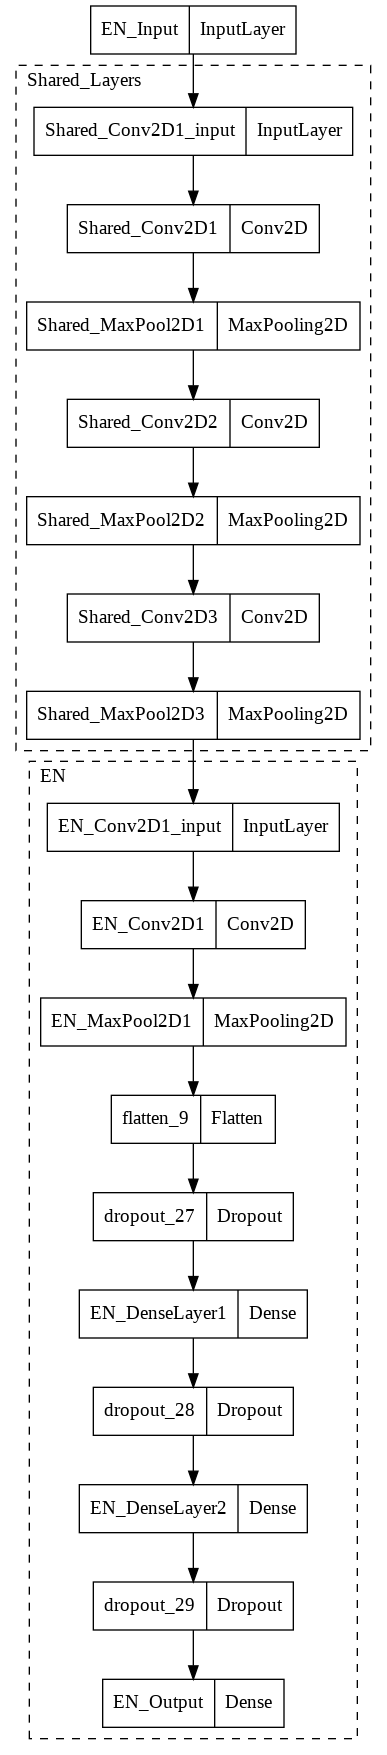

In [ ]:
inputEN = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='EN_Input')
inputES = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='ES_Input')
inputFR = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='FR_Input')

shared = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(9,9), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D1'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D1'),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D2'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D2'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D3'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D3')
    ],
    name='Shared_Layers'
)

sharedLayersEN = shared(inputEN)
sharedLayersES = shared(inputES)
sharedLayersFR = shared(inputFR)

layersEN = languagelayers(NUM_LABELS_EN,'EN')(sharedLayersEN)
layersES = languagelayers(NUM_LABELS_ES,'ES')(sharedLayersES)
layersFR = languagelayers(NUM_LABELS_FR,'FR')(sharedLayersFR)


modelFullEN = tf.keras.Model(
    inputs=[inputEN],
    outputs=[layersEN],
    name='Full_Model_EN'
)


modelFullEN.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullEN, expand_nested=True)

In [ ]:
modelFullEN.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [ ]:
RUN = '1'

ext = '-FULL-EN'

training_callbackFULLEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# model.predict(testdatasetEN)

In [ ]:
historyEN = modelFullEN.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)


Epoch 1/75
30/30 [==============================] - 3s 46ms/step - loss: 2.7556 - Categorical_Accuracy: 0.0653 - AUC: 0.5038 - val_loss: 2.6960 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5499 - lr: 1.0000e-04
Epoch 2/75
30/30 [==============================] - 1s 14ms/step - loss: 2.7049 - Categorical_Accuracy: 0.0893 - AUC: 0.5296 - val_loss: 2.6956 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5544 - lr: 1.0000e-04
Epoch 3/75
30/30 [==============================] - 1s 14ms/step - loss: 2.6995 - Categorical_Accuracy: 0.0900 - AUC: 0.5370 - val_loss: 2.6928 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5582 - lr: 1.0000e-04
Epoch 4/75
30/30 [==============================] - 1s 14ms/step - loss: 2.6974 - Categorical_Accuracy: 0.0987 - AUC: 0.5393 - val_loss: 2.6880 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5613 - lr: 1.0000e-04
Epoch 5/75
30/30 [==============================] - 1s 17ms/step - loss: 2.6843 - Categorical_Accuracy: 0.1053 - AUC: 0.5623 - val_loss: 2.6826 

In [ ]:
# print(modelFullEN.layers[-2].weights)

Model: "Full_Model_ES"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ES_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

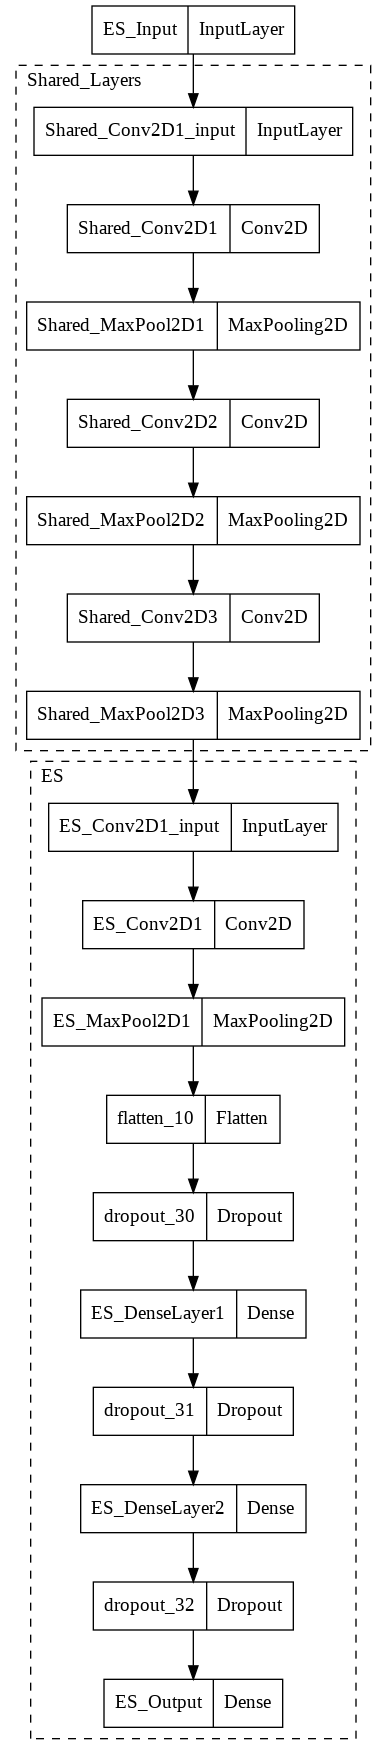

In [ ]:
modelFullES = tf.keras.Model(
    inputs=[inputES],
    outputs=[layersES],
    name='Full_Model_ES'
)

modelFullES.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullES, expand_nested=True)

In [ ]:
modelFullES.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [ ]:
# print(modelFullES.layers[-2].weights)

In [ ]:
ext = '-FULL-ES'
training_callbackFULLES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyES = modelFullES.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
30/30 [==============================] - 3s 49ms/step - loss: 2.4712 - Categorical_Accuracy: 0.0867 - AUC: 0.5333 - val_loss: 2.4229 - val_Categorical_Accuracy: 0.1120 - val_AUC: 0.5931 - lr: 1.0000e-04
Epoch 2/75
30/30 [==============================] - 0s 14ms/step - loss: 2.4279 - Categorical_Accuracy: 0.0900 - AUC: 0.5357 - val_loss: 2.4169 - val_Categorical_Accuracy: 0.1320 - val_AUC: 0.6131 - lr: 1.0000e-04
Epoch 3/75
30/30 [==============================] - 1s 14ms/step - loss: 2.4063 - Categorical_Accuracy: 0.0820 - AUC: 0.5676 - val_loss: 2.4063 - val_Categorical_Accuracy: 0.1320 - val_AUC: 0.6332 - lr: 1.0000e-04
Epoch 4/75
30/30 [==============================] - 1s 14ms/step - loss: 2.3965 - Categorical_Accuracy: 0.0927 - AUC: 0.5703 - val_loss: 2.3856 - val_Categorical_Accuracy: 0.1520 - val_AUC: 0.6512 - lr: 1.0000e-04
Epoch 5/75
30/30 [==============================] - 1s 15ms/step - loss: 2.3705 - Categorical_Accuracy: 0.1053 - AUC: 0.5960 - val_loss: 2.3631 

Model: "Full_Model_FR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FR_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

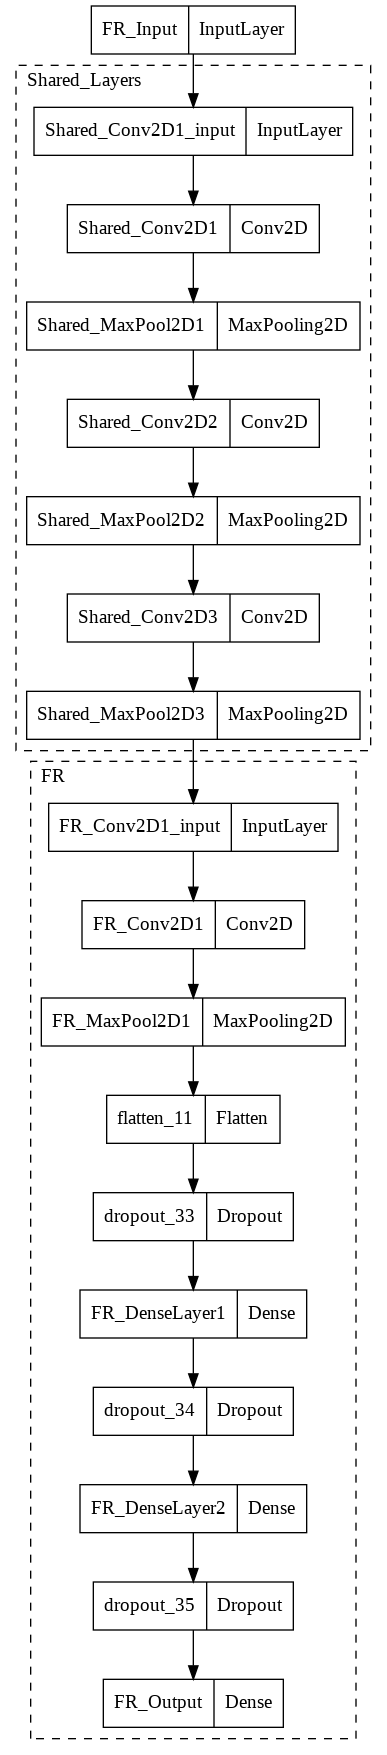

In [ ]:
modelFullFR = tf.keras.Model(
    inputs=[inputFR],
    outputs=[layersFR],
    name='Full_Model_FR'
)

modelFullFR.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullFR, expand_nested=True)

In [ ]:
modelFullFR.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [ ]:
ext = '-FULL-FR'
training_callbackFULLFR = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyFR = modelFullFR.fit(
    x = traindatasetFR,
    validation_data = valdatasetFR,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLFR,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
30/30 [==============================] - 3s 47ms/step - loss: 2.8720 - Categorical_Accuracy: 0.0873 - AUC: 0.5235 - val_loss: 2.6715 - val_Categorical_Accuracy: 0.0960 - val_AUC: 0.6121 - lr: 1.0000e-04
Epoch 2/75
30/30 [==============================] - 1s 14ms/step - loss: 2.6948 - Categorical_Accuracy: 0.0893 - AUC: 0.5589 - val_loss: 2.6466 - val_Categorical_Accuracy: 0.1200 - val_AUC: 0.6572 - lr: 1.0000e-04
Epoch 3/75
30/30 [==============================] - 1s 14ms/step - loss: 2.6529 - Categorical_Accuracy: 0.1207 - AUC: 0.5950 - val_loss: 2.6161 - val_Categorical_Accuracy: 0.1480 - val_AUC: 0.7043 - lr: 1.0000e-04
Epoch 4/75
30/30 [==============================] - 1s 15ms/step - loss: 2.6235 - Categorical_Accuracy: 0.1213 - AUC: 0.6198 - val_loss: 2.5687 - val_Categorical_Accuracy: 0.1960 - val_AUC: 0.7429 - lr: 1.0000e-04
Epoch 5/75
30/30 [==============================] - 1s 15ms/step - loss: 2.5794 - Categorical_Accuracy: 0.1407 - AUC: 0.6453 - val_loss: 2.4958 

In [ ]:
shared.trainable = False

In [ ]:
newSharedLayers = shared(inputEN)
newLayersEN = languagelayers(NUM_LABELS_EN,'EN')(newSharedLayers)

modelENRetrain = tf.keras.Model(
    inputs=inputEN,
    outputs=newLayersEN,
    name='ENModelRetrained'
)

In [ ]:
modelENRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

# modelEN.evaluate(testdatasetEN)

In [ ]:
ext = '-RETRAIN-EN'
training_callbackRETRAINEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyENRetrain = modelENRetrain.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
30/30 [==============================] - 2s 29ms/step - loss: 3.2492 - Categorical Accuracy: 0.0820 - AUC: 0.5251 - val_loss: 2.6514 - val_Categorical Accuracy: 0.1240 - val_AUC: 0.6108 - lr: 1.0000e-04
Epoch 2/75
30/30 [==============================] - 1s 11ms/step - loss: 2.8011 - Categorical Accuracy: 0.1073 - AUC: 0.5557 - val_loss: 2.6206 - val_Categorical Accuracy: 0.1540 - val_AUC: 0.6801 - lr: 1.0000e-04
Epoch 3/75
30/30 [==============================] - 1s 11ms/step - loss: 2.6653 - Categorical Accuracy: 0.1220 - AUC: 0.6053 - val_loss: 2.5902 - val_Categorical Accuracy: 0.1680 - val_AUC: 0.7329 - lr: 1.0000e-04
Epoch 4/75
30/30 [==============================] - 1s 14ms/step - loss: 2.6406 - Categorical Accuracy: 0.1293 - AUC: 0.6149 - val_loss: 2.5382 - val_Categorical Accuracy: 0.2000 - val_AUC: 0.7885 - lr: 1.0000e-04
Epoch 5/75
30/30 [==============================] - 1s 12ms/step - loss: 2.5730 - Categorical Accuracy: 0.1613 - AUC: 0.6495 - val_loss: 2.4855 

In [ ]:
# print(modelENRetrain.layers[-2].weights)

In [ ]:
newSharedLayers = shared(inputES)
newLayersES = languagelayers(NUM_LABELS_ES,'ES')(newSharedLayers)

modelESRetrain = tf.keras.Model(
    inputs=inputES,
    outputs=newLayersES,
    name='ESModelRetrained'
)

modelESRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-ES'
training_callbackRETRAINES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyESRetrain = modelESRetrain.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
30/30 [==============================] - 2s 28ms/step - loss: 2.8528 - Categorical Accuracy: 0.0660 - AUC: 0.5034 - val_loss: 2.4194 - val_Categorical Accuracy: 0.1120 - val_AUC: 0.5892 - lr: 1.0000e-04
Epoch 2/75
30/30 [==============================] - 1s 14ms/step - loss: 2.5142 - Categorical Accuracy: 0.0933 - AUC: 0.5424 - val_loss: 2.3966 - val_Categorical Accuracy: 0.1720 - val_AUC: 0.6649 - lr: 1.0000e-04
Epoch 3/75
30/30 [==============================] - 1s 11ms/step - loss: 2.4314 - Categorical Accuracy: 0.1040 - AUC: 0.5714 - val_loss: 2.3690 - val_Categorical Accuracy: 0.1960 - val_AUC: 0.7235 - lr: 1.0000e-04
Epoch 4/75
30/30 [==============================] - 1s 11ms/step - loss: 2.3641 - Categorical Accuracy: 0.1213 - AUC: 0.6138 - val_loss: 2.3258 - val_Categorical Accuracy: 0.2420 - val_AUC: 0.7605 - lr: 1.0000e-04
Epoch 5/75
30/30 [==============================] - 1s 12ms/step - loss: 2.3287 - Categorical Accuracy: 0.1393 - AUC: 0.6352 - val_loss: 2.2697 

In [ ]:
newSharedLayers = shared(inputFR)
newLayersFR = languagelayers(NUM_LABELS_FR,'FR')(newSharedLayers)

modelFRRetrain = tf.keras.Model(
    inputs=inputFR,
    outputs=newLayersFR,
    name='FRModelRetrained'
)

modelFRRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-FR'
training_callbackRETRAINFR = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyFRRetrain = modelFRRetrain.fit(
    x = traindatasetFR,
    validation_data = valdatasetFR,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINFR,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/75
30/30 [==============================] - 2s 29ms/step - loss: 3.1398 - Categorical Accuracy: 0.0853 - AUC: 0.5084 - val_loss: 2.6444 - val_Categorical Accuracy: 0.1520 - val_AUC: 0.6319 - lr: 1.0000e-04
Epoch 2/75
30/30 [==============================] - 1s 11ms/step - loss: 2.7954 - Categorical Accuracy: 0.0840 - AUC: 0.5500 - val_loss: 2.6219 - val_Categorical Accuracy: 0.2100 - val_AUC: 0.6906 - lr: 1.0000e-04
Epoch 3/75
30/30 [==============================] - 1s 11ms/step - loss: 2.7030 - Categorical Accuracy: 0.0993 - AUC: 0.5736 - val_loss: 2.6051 - val_Categorical Accuracy: 0.2360 - val_AUC: 0.7228 - lr: 1.0000e-04
Epoch 4/75
30/30 [==============================] - 1s 11ms/step - loss: 2.6600 - Categorical Accuracy: 0.1027 - AUC: 0.6017 - val_loss: 2.5842 - val_Categorical Accuracy: 0.3060 - val_AUC: 0.7475 - lr: 1.0000e-04
Epoch 5/75
30/30 [==============================] - 1s 12ms/step - loss: 2.5853 - Categorical Accuracy: 0.1420 - AUC: 0.6451 - val_loss: 2.5380 

In [ ]:
modelENRetrain.evaluate(testdatasetEN)

250/250 [==============================] - 2s 5ms/step - loss: 0.7921 - Categorical Accuracy: 0.7400 - AUC: 0.9749


[0.7920727133750916, 0.7400000095367432, 0.9748554825782776]

In [ ]:
modelESRetrain.evaluate(testdatasetES)

250/250 [==============================] - 2s 5ms/step - loss: 0.6762 - Categorical Accuracy: 0.7400 - AUC: 0.9772


[0.6761702299118042, 0.7400000095367432, 0.9772154092788696]

In [ ]:
modelFRRetrain.evaluate(testdatasetFR)

250/250 [==============================] - 2s 5ms/step - loss: 0.7502 - Categorical Accuracy: 0.7400 - AUC: 0.9756


[0.7502241730690002, 0.7400000095367432, 0.9756090641021729]

In [ ]:
# !mkdir savedmodels

In [ ]:
shared.save('savedmodels/sharedmodel')
modelFullEN.save('savedmodels/fullmodelEN')
modelFullES.save('savedmodels/fullmodelES')
modelFullFR.save('savedmodels/fullmodelFR')
modelENRetrain.save('savedmodels/modelENRetrain')
modelESRetrain.save('savedmodels/modelESRetrain')
modelFRRetrain.save('savedmodels/modelFRRetrain')

INFO:tensorflow:Assets written to: savedmodels/sharedmodel/assets


INFO:tensorflow:Assets written to: savedmodels/sharedmodel/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelEN/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelEN/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelES/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelES/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelFR/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelFR/assets


INFO:tensorflow:Assets written to: savedmodels/modelENRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelENRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelESRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelESRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelFRRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelFRRetrain/assets


In [ ]:
# !zip -r /content/savedmodels.zip /content/savedmodels
#

  adding: content/savedmodels/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/keras_metadata.pb (deflated 94%)
  adding: content/savedmodels/fullmodelEN/variables/ (stored 0%)
  adding: content/savedmodels/fullmodelEN/variables/variables.index (deflated 68%)
  adding: content/savedmodels/fullmodelEN/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/savedmodels/fullmodelEN/saved_model.pb (deflated 90%)
  adding: content/savedmodels/fullmodelEN/assets/ (stored 0%)
  adding: content/savedmodels/sharedmodel/ (stored 0%)
  adding: content/savedmodels/sharedmodel/keras_metadata.pb (deflated 92%)
  adding: content/savedmodels/sharedmodel/variables/ (stored 0%)
  adding: content/savedmodels/sharedmodel/variables/variables.index (deflated 46%)
  adding: content/savedmodels/sharedmodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/savedmodels/sharedmodel/saved_model.pb (deflated 90%)
  a

In [ ]:
# from google.colab import files
# files.download('/content/savedmodels.zip')
#

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # %reload_ext tensorboard
# # %tensorboard --logdir logs
#

In [ ]:
# !zip -r /content/logs.zip /content/logs
#

  adding: content/logs/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/train/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/train/events.out.tfevents.1638882871.aced5336b311.87.19.v2 (deflated 86%)
  adding: content/logs/model1-1-RETRAIN-EN/train/events.out.tfevents.1638882551.aced5336b311.87.7.v2 (deflated 87%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/events.out.tfevents.1638882552.aced5336b311.87.8.v2 (deflated 77%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/events.out.tfevents.1638882873.aced5336b311.87.20.v2 (deflated 80%)
  adding: content/logs/model1-1-RETRAIN-ES/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/train/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/train/events.out.tfevents.1638882936.aced5336b311.87.21.v2 (deflated 86%)
  adding: content/logs/model1-1-RETRAIN-ES/train/events.out.tfevents

In [ ]:
# from google.colab import files
# files.download('/content/logs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>